# Course outline

This is compiled material from the course Implementing ANNs with TensorFlow which I have co-taught in 2021/22 and 2022/23 at Osnabrück University. Some material was presented in a different format and is thus not yet part of this repository. That includes weekly homeworks as well as topics such as Autoencoders, NLP, ResNet and DenseNet architectures and Deep Reinforcement Learning.

- 0. Basic tensor operations in TensorFlow


- 1. From biological neurons to logic gates, to activation functions to universal function approximation (build your first ANN from scratch)


- 2. Learning in ANNs: Gradient Descent, Backpropagation, and Automatic Differentiation (build your first ANN from scratch, including backpropagation and training loop)


- 3. Basic usage of TensorFlow's automatic differentiation: The GradientTape context manager


- 4. Modules, Layers, and Models. An introduction to the Keras Subclassing API


- 5. Keras metrics for keeping track of losses, accuracies etc.


- 6. Loss functions and optimizers


- 7. Putting it together: Using TensorBoard to log training data and implementing a subclassed model using keras metrics and a custom training loop.


- 8. Convolutional Neural Networks (incl. interactive widget)


- 9. Regularization: Avoiding overfitting with L1/L2 penalties, dropout, normalization and data augmentation


- 10. Optimization difficulties: Vanishing and exploding gradients. Weight initialization, normalization and residual/skip connections as partial solutions


- 11. Recurrent Neural Networks: From unrolled recurrence to dynamically unrolled custom recurrent cells


- (12. Autoencoders)


- 13. Generative Models


- (14. Transformers and NLP)


- (15. Deep Reinforcement Learning)

# Introduction: Implementing Artificial Neural Networks (ANNs) with TensorFlow

The course starts with this first session (this notebook) on the basic notion of a neural network, their coarse similarities to biological neural networks. This session will introduce the notion of perceptrons, the general ideas of McCulloch and Pitts on expressing logical functions with networks of neurons. You will learn how to wire neurons into a network and set weights by hand to express a logical function. We will then go on to look at how a collection of such neurons can be expressed with the notion of a "layer" using matrix multiplication to perform the computation of multiple neurons in parallel. We will then connect a number of such layers to form a Multi-Layer-Perceptron, the simplest kind of ANN.



## From biological neurons to ANNs

Neurons can be abstracted to three core elements: a **cell body (soma)**, an **axon** and **dendrites**.

Dendrites take in electrical input from other firing neurons. The cell body accumulates electrical potential until a **threshold** is reached and the neuron spikes an action potential, leading to an electric discharge via the axon, which will eventually reach the dendrites of other neurons.


### Neuron and Computation

How do neurons when reduced to these characteristics relate to computation? Already in 1943 [Warren McCulloch and Walter Pitts](https://link.springer.com/article/10.1007/BF02478259) studied the relation between abstract neurons and logical operators such as AND, OR and NOT. Since all of logic can be reduced to this minimal set of operators, combining neurons in a network allows to implement arbitrary logical computations based on inputs.

A McCulloch-Pitts neuron outputs either 0 or 1 just as a logical operator/function would.


## Logical functions

Let's implement an arbitrary logical function that takes three boolean truth value arguments **a**, **b**, and **c** and evaluates the following logical expression:

$$ \neg a \rightarrow (b \land \neg c) $$

which is also equivalent to

$$ a \lor (b \land \neg c) $$

Let's implement it in code:

In [1]:
def logical_function(arguments:tuple):
    
    # not(a) -> (b and not c)
    
    a,b,c = arguments
    
    if a:
        return 1.
    else:
        if (b and not c):
            return 1
        else:
            return 0
        
all_possible_arguments = \
            [(0,0,0),
             (1,0,0),
             (1,1,0),
             (1,1,1),
             (1,0,1),
             (0,1,0),
             (0,1,1),
             (0,0,1)]

logical_function(all_possible_arguments[0])

0

Now we want to see that a **perceptron** can express this function.

Before applying a threshold function (activation function), the output of a perceptron is given by

$$ o = \sum_i^m W_i x_i + b$$

or, in matrix notation:

$$ o = W x  + b$$

Note that you often also see $o = x W + b$ - it all depends on whether the input vector x is a row or a column vector. 

On this scalar output, we apply the thresholding function to determine whether the perceptron unit is "firing" (it outputs 1) or not (it outputs 0). The following threshold function is known as the **heaviside-step function**:

$$
\sigma(x) = \begin{cases}
    1 ,& \text{if } x > 0\\
    0,              & \text{otherwise}
\end{cases}
$$

To relate this back to coarse biological inspiration, we can read the weights W as analogous to the synaptic strengths of dendritic connections, and the bias as shifting the threshold.

This is all we need to know in order to define a perceptron in code:

In [2]:
import numpy as np

def heaviside_step(x):
    """
    Hard binary threshold function.
    
    A unit fires if a threshold of 0 is surpassed.
    """
    return 1. if x > 0 else 0.

class Perceptron(object):
    def __init__(self, weight_values, bias, threshold_function=heaviside_step):
        
        self.weights = np.array([weight_values], dtype=np.float32)
        self.bias = bias
        self.threshold_function = threshold_function
    
    def __call__(self, x:np.ndarray):
        
        o = self.weights @ x + self.bias # where "@" is matrix multiplication (or dot product)
        
        return self.threshold_function(o)

Can we configure the perceptron to express the logical function from above? The bias shifts the threshold for the weighted sum of the arguments at which the unit returns a 1. If the bias is very high, the threshold will be very low and the unit will always fire, regardless of the input. If the bias is a large negative number, the threshold will be high, meaning the weights and their input need to be large numbers.

In [3]:
p_weights = [2, 1, -1] # solution
p_bias = 0

perceptron = Perceptron(weight_values=p_weights, bias=p_bias)

assert np.all(
    [logical_function(x) == perceptron(np.array(x)) for x in all_possible_arguments]), \
"the perceptron is not functionally equivalent ot the logical function"

## The logic of (binary) Multilayer Perceptrons (MLP)

The previous logical expression could be modeled with a single perceptron. 
But what about the following logical function?

$$ (a \lor b) \land \neg(a \land b)$$

This is called the XOR operator for "exclusive or".

It turns out that a single perceptron can not express XOR since it is not linearly separable. Perceptrons can only express a linear function.

The **linear** separatrix (decision boundary) of a perceptron is given by
$$ w_1x_1+w_2x_2+...+w_nx_n+b = 0$$

![https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Separability_YES.svg/1280px-Separability_YES.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Separability_YES.svg/1280px-Separability_YES.svg.png)

To express the non-linear function XOR, we can stack perceptrons on top of each other, where one perceptron can take the outputs of other perceptrons as its input arguments. This is exactly equivalent to how we can combine logical operators to create composite logical functions (such as XOR!).

To see that XOR is not learnable with a single linear decision boundary, we can try to draw one, separating input for which a zero should be returned (red points) from input for which a one should be returned (blue points):

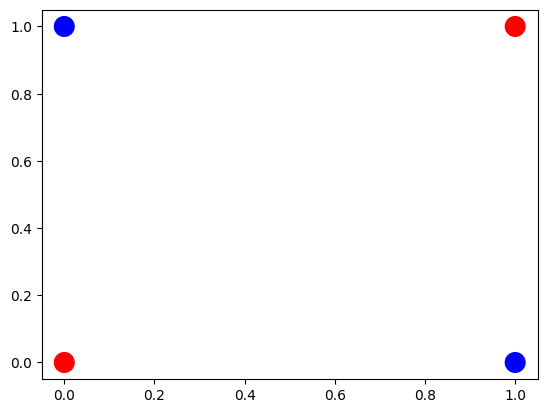

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=[1,0],y=[1,0], s=[200,200],c="red")
plt.scatter(x=[1,0,],y=[0,1], s=[200,200],c="blue")
plt.show()

In [5]:
def xor(x):
    a,b = x
    return (a or b) and (not (a and b))

all_possible_arguments = [
    (0,0),
    (0,1),
    (1,0),
    (1,1)
]

In [6]:
# a or b
p1_weights = [1,1]
p1_bias = 0

# a and b
p2_weights = [0.5,0.5]
p2_bias = -0.5

# p1 and not p2
p3_weights = [0.5,-0.5]
p3_bias = 0

perceptron_1 = Perceptron(p1_weights, p1_bias)
perceptron_2 = Perceptron(p2_weights, p2_bias)
perceptron_3 = Perceptron(p3_weights, p3_bias)

def wire_perceptrons(x):
    """
    perceptron 1 and 2 take (a,b) as inputs.
    perceptron 3 takes the outputs of perceptron 1 and perceptron 2 as inputs.
    """
    
    return perceptron_3([perceptron_1(x),perceptron_2(x)])

# evaluate that our simple handwired network implements xor
assert np.all([xor(x) == wire_perceptrons(np.array(x)) for x in all_possible_arguments]), "Not equivalent to XOR"

We just implemented an artificial neural network that implements a non-linear logical function by setting all the weights by hand!

What about other kinds of functions, like non-binary functions? So far, with the heaviside-step activation function, our perceptron can only output 1 or 0..

So to get a continuous output, we need to use a continuously valued threshold function. One class of such activation functions is logistic functions: e.g. sigmoid and hyperbolic tangent:

## Sigmoid activation function

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

- saturates towards 0 and 1
- can thus be read as a probability

## Tanh activation function

$$ \sigma(x) = \frac{(e^x – e^{-x})}{(e^x + e^{-x})} $$

- saturates at -1 and 1


## No activation function (linear activation)

$$ \sigma(x) = x $$

- can lead to arbitrary output values depending on what the pre-activation is
- if the pre-activation is discrete valued, the output will also be

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x) + np.exp(-x))

def linear(x):
    return x

In [8]:
perceptron = Perceptron(weight_values=[0.5, -0.6, 0.1], bias=0, threshold_function=sigmoid)

perceptron(np.array([-3,0,3]))

array([0.23147522])

## Layers of perceptrons

As you will see, such perceptrons with non-linear activation functions present the basic units of artificial neural networks, however it is common to talk about layers of units and not single units.

In the XOR example we had two perceptrons that took the raw values (a,b) as inputs. These can be considered to constitute a **layer** of two perceptrons. For readability and for matrix multiplication efficiency we want to implement a layer of perceptrons as a single object rather than having an object for each unit.

In [9]:
class PerceptronLayer(object):
    def __init__(self, weights, biases, activation_function=sigmoid):
        
        self.weights = np.array(weights)
        self.bias = np.array(biases)
        self.activation_function = activation_function
        
    def __call__(self, x):
        
        output = (x @ self.weights + self.bias)
        
        return self.activation_function(output)

You may notice that this looks exactly the same as before.

This time, we pass a different shape of the weights array, turning the dot product (@) into a matrix-vector multiplication.

Let's instantiate a layer of **4 perceptrons** that each connect to **3 input values**.

In [10]:
weights = np.array([[1,3,4],
                    [-2,-4,1],
                    [3,1,9],
                    [0,1,0]]).T

biases = np.array([0,0,0,0])

print(f"weights have shape {weights.shape}")

perceptron_layer = PerceptronLayer(weights, biases)

print("output:", perceptron_layer([0.4, 1.2, 3.1]))

weights have shape (3, 4)
output: [0.99999992 0.07585818 1.         0.76852478]


# Multi-Layer-Perceptrons


From the layer with 4 units we get a 4 dimensional vector instead of a single scalar as the output. 

How can we stack these layers to construct an even more expressive neural network?

All we need to do is to make sure we obey the rules of matrix multiplication!

Matrix multiplication requires the inner dimensions of the two matrices match, e.g. (a,b) and (b,c).

Given a matrix **W** (the weights of our layer) and a vector **x** (the inputs to the layer), we need the dimensionality of **x** to match the number of columns in the matrix. The output then is a vector with a dimensionality of the number of rows of **W**. The weights shape can be read as (n_inputs, n_outputs) and the input always has shape (batch_size, n_inputs), such that a matrix multiplication with **W** leads to shape (batch_size, n_outputs).

If we have data x with shape (1,10) and a first layer with a weight shape of (10,5), we get a vector of shape (1,5) as the output. If we want to apply another layer to this output, its weights need to be of shape (5, n_units).

Let's define such a network, this time using randomly initialized weights so we can also scale it up:

In [11]:
def random_weights(*shape):
    return np.random.normal(size=shape)

class MultiLayerPerceptron(object):
    
    def __init__(self, n_inputs):
        
        self.layer_1 = PerceptronLayer(weights=random_weights(n_inputs, 64),
                                       biases=np.zeros(64))
        
        self.layer_2 = PerceptronLayer(weights=random_weights(64, 32),
                                       biases=np.zeros(32))
        
        self.layer_3 = PerceptronLayer(weights=random_weights(32, 16),
                                       biases=np.zeros(16))
        
        self.output_layer = PerceptronLayer(weights=random_weights(16, 1),
                                            biases=np.zeros(1),
                                            activation_function=linear)

    def __call__(self, x):
        
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        
        return self.output_layer(x)
    
mlp = MultiLayerPerceptron(n_inputs=3)

observation = [1, -1, 0.5]
prediction = mlp(observation)
print("output:", prediction)

output: [1.27902114]


# Universal Function Approximation Theorem

What can we do with this MLP architecture?

According to the universal approximation theorems, given enough units in a single layer MLP with a non-linearity, we can approximate any continuous function. With multiple layers, we can usually achieve the same approximation with less units.

MLPs present a powerful tool to learn from data, but it is not as simple as this finding may seem to suggest:

- just because a solution exists for a network architecture, it does not mean we will find it (learning weights and biases is hard)
- fitting to observed data does not mean the network will perform as well on unseen data  (generalization is hard)


# How to update the weights of an MLP?

Now suppose we have a set of observations (data) and we know the true values (labels) of what we want to predict.

**How can we adapt the weights (and the bias values) of our multi-layer perceptron to make model predictions match the observed ground truth?**

This will be addressed in detail in notebook 02.